In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import pickle
import re
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
from skimage.io import imread
import matplotlib.pyplot as plt
import cv2
from sklearn import svm
from skimage import io
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.filters import try_all_threshold
from skimage.filters import threshold_isodata
from skimage.filters import threshold_li
from skimage.filters import threshold_mean
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu
from skimage.filters import threshold_triangle
from skimage.filters import threshold_yen
from skimage.filters import threshold_local
from skimage.filters import sobel
from skimage.filters import median

from skimage.measure import label

from skimage.morphology import disk
from skimage.morphology import opening,closing,disk

from skimage import util 
from skimage.color import label2rgb

import imageio

In [6]:
def create_graph():
    with gfile.FastGFile('classify_image_graph_def.pb', 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

def extract_features(image): #image is the path of image
    create_graph() #necessary for getting tensors

    with tf.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

        image_data = gfile.FastGFile(image, 'rb').read()

        predictions = sess.run(next_to_last_tensor, {'DecodeJpeg/contents:0': image_data})
        return np.squeeze(predictions)

In [17]:
path='88AJ_OCMR+.jpg' #put here the path of image you want to test

In [8]:
features=extract_features(path) #put here the path of image you want to test

Instructions for updating:
Use tf.gfile.GFile.


In [9]:
def test(image):
    result = {}

    #hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,Bin)
    hog = cv2.HOGDescriptor()
    h,w = image.shape
    # 64*128滑窗检测，跳数为8, 即把图像划分为多个子图，检测子图是否属于legion部分    
    for x in range(0,h-128,4):
        for y in range(0,w-64,8):
            block = image[x:x+129,y:y+65]
            #print(block.shape)
            feature = hog.compute(block)
            if feature is None:
                continue
            else:
                feature = feature.ravel().reshape(1,3780) 
                prob_temp=model_frame.predict_proba(feature)[0][0]
                
                if prob_temp > 0.99: 
                    result[(x,y)] = 1
    return result

 
#  Merging all all sub-areas containing the lesions into a larger areas having lesions
def drawVirtrualBox2(image_ori,image_trai, res):
    count = 0
    for k,v in res.items():
        if v==0:
            continue
        x,y = k
        maxy, maxx, minx, miny = y + 64, x + 128, x, y
        for k1 in res.keys():
            x1,y1 = k1
            if minx<=x1<=maxx and miny<=y1<=maxy or miny<=y1+64<=maxy:
                res[k1]=0
                maxy = max(maxy, y1+64)
                maxx = max(maxx, x1+128)
                miny = min(miny, y1)
                minx = min(minx, x1)
        count +=1
        cv2.rectangle(image_ori, (miny,minx), (maxy,maxx), (0,0,255), 2)
        cv2.rectangle(image_trai, (miny,minx), (maxy,maxx), (0,0, 255), 2)
        
    #cv2.imshow("result", image)  # It cannot be used in jupyter notebook
    cv2.imwrite('result_merged_Box_ori.jpg', image_ori)
    cv2.imwrite('result_merged_Box_trai.jpg', image_trai)

# Detect all sub-areas containing the lesions
def drawVirtrualBox(image_ori,image_trai,res):
    for v in res.keys():
        x,y = v
        cv2.rectangle(image_ori, (y,x), (y+64,x+128), (0,0,255) ,1)
        cv2.rectangle(image_trai, (y,x), (y+64,x+128), (0,0,255) ,1)
   
    
    cv2.imwrite('result_allBox_ori.jpg', image_ori)
    cv2.imwrite('result_allBox_trai.jpg', image_trai)
    #cv2.imshow('result',image)  # It cannot be used in jupyter notebook


In [10]:
# load the model svm and its weights that we had trained above. 
with open('sample_svm.pickle','rb') as fr:
    model_classification = pickle.load(fr)
with open('training_result.pickle','rb') as fr:
    model_frame = pickle.load(fr)


In [11]:
#here to add the annotation function of Johnathan

def annotation_and_save():
    img = io.imread(path)
    img = color.rgb2gray(img)
    thresh_yen = threshold_yen(img)
    
    # opening used to remove line artifacts
    binary_yen = opening(img > thresh_yen,disk(5))   
    
    yen_red = np.zeros((img.shape[0],img.shape[1]))
    yen_red[:,:] = binary_yen*255

    contour_im = sobel(img)
    thresh = threshold_triangle(contour_im)

    outline_binary = contour_im > thresh
    outline_binary_neg = util.invert(outline_binary)
    
    x,y = img.shape

    overlay_rgb = np.ones((x,y,3))
    overlay_rgb[:,:,0] = binary_yen
    overlay_rgb[:,:,1] = outline_binary_neg
    
    io.imsave('traitement.jpg', overlay_rgb)
    #io.imsave('original.jpg',)

In [12]:
annotation_and_save()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [18]:
def print_frame_annotation():
    img = np.asarray(Image.open(path).convert('L'))
    result = test(img)    
    drawVirtrualBox(cv2.imread(path),cv2.imread("traitement.jpg"),result)
    drawVirtrualBox2(cv2.imread(path),cv2.imread("traitement.jpg"),result)
    # show the testing results
    fig, axes = plt.subplots(ncols = 4, figsize=(16, 10))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 2, 1)
    ax[1] = plt.subplot(1, 2, 2)
    img_ori = mpimg.imread(path)
    ax[0].imshow(img_ori,cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    result_allBox_ori = mpimg.imread('result_allBox_ori.jpg')
    ax[1].imshow(result_allBox_ori,cmap=plt.cm.gray)
    ax[1].set_title('All sub-areas detected  ')
    plt.show()



    fig, axes = plt.subplots(ncols = 6, figsize=(16, 10))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 2, 1)
    ax[1] = plt.subplot(1, 2, 2)

    result_trai = mpimg.imread('traitement.jpg')
    ax[0].imshow(result_trai,cmap=plt.cm.gray)
    ax[0].set_title('Image after post-traitment')

    result_allBox_trai = mpimg.imread('result_allBox_trai.jpg')
    ax[1].imshow(result_allBox_trai,cmap=plt.cm.gray)
    ax[1].set_title('All sub-areas detected')
    plt.show()

    fig, axes = plt.subplots(ncols = 6, figsize=(16, 10))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 2, 1)
    ax[1] = plt.subplot(1, 2, 2)

    result_merged_Box_ori = mpimg.imread('result_merged_Box_ori.jpg')
    ax[0].imshow(result_merged_Box_ori,cmap=plt.cm.gray)
    ax[0].set_title('Area detected')

    result_merged_Box_trai = mpimg.imread('result_merged_Box_trai.jpg')
    ax[1].imshow(result_merged_Box_trai,cmap=plt.cm.gray)
    ax[1].set_title('Area detected')
    plt.show()

The probability with lesions:  0.7210514208252612
We classify the MRI image as uncertain. But we still display the frame and annotation of possible lesions.


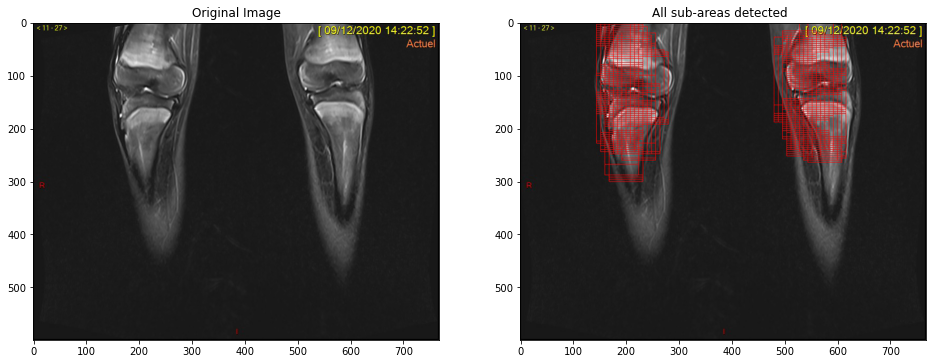

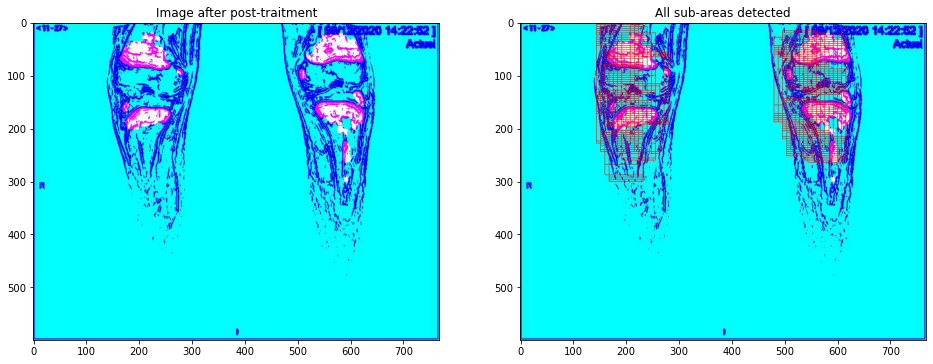

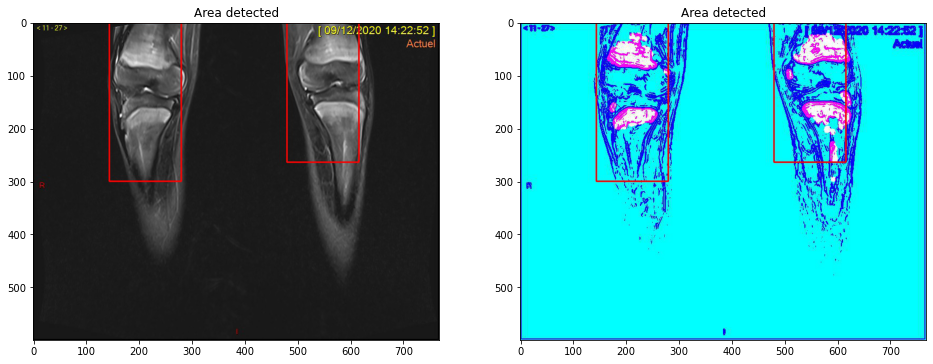

In [19]:
proba=model_classification.predict_proba(features.reshape(1,-1))[0,0]
print('The probability with lesions: ',proba)
if proba>0.8:
    print('We classify the MRI image as with lesions. And we display the frame and annotation of possible lesions.')
    print_frame_annotation()
elif proba<0.2:
    print('We classify the MRI image as without lesions.')
else:
    print('We classify the MRI image as uncertain. But we still display the frame and annotation of possible lesions.')
    print_frame_annotation()